---
title: OSI - Oil Spill Index
subtitle: Learn how to use the Oil Spill Index (OSI) to detect oil spills using Sentine-2 data.
authors:
  - name: Juraj Zvolenský
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["template"]
releaseDate: 2025-01-29
datePublished: 2025-01-29
dateModified: 2025-06-10
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Read EOPF-Zarr](#Read-EOPF-Zarr)

(Introduction)=
## Introduction

The OSI (Oil Spill Index) uses visible Sentinel-2 bands to display oil spills over water in the costal/marine environment. The OSI is constructed by summing-up the bands representing the shoulders of absorption features of oil as numerator and the band located nearest to the absorption feature as denominator to discriminate oil spill as below.

OSI = (B03 + B04) / B02

The original idea was created by Sankaran Rajendran and is available in the Sentinel Hub documentation [here](https://custom-scripts.sentinel-hub.com/sentinel-2/oil-spill-index/).

:::{hint} Overview
**Questions**
- How to access Sentinel-2 Zarr data via STAC?
- How to calculate the OSI (Oil Spill Index) using Sentinel-2 data?
- Why is it useful?

**Objectives**
- Access Sentinel-2 Zarr data via STAC.
- Calculate the OSI (Oil Spill Index) using Sentinel-2 data.
- Understand the usefulness of the OSI for detecting oil spills.
- Learn how to visualize the OSI results.
:::

(Setup)=
## Setup
Start importing the necessary libraries

In [ ]:
import os
import pystac_client
from pystac_client import CollectionSearch
import xarray as xr
from datetime import datetime
import s3fs
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

from shapely import geometry

from distributed import LocalCluster

In [ ]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

In [ ]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:notebook-data"
prefix = "tutorial_data/cpm_v260/"
endpoint_url = "https://objects.eodc.eu:443"

pattern = "S2?_MSIL2A_*_N0500_R091_T40KEC_*.zarr"

fs = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={"endpoint_url": endpoint_url}
)

handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
if handlers_to_unregister:
    fs.s3.meta.events._emitter.unregister("before-parameter-build.s3", handlers_to_unregister[0])
 
s3_glob_path = f"{bucket}/{prefix}{pattern}"
matched_paths = fs.glob(s3_glob_path)
 
zarr_paths = [f"{endpoint_url}/{path}" for path in matched_paths]
 
len(zarr_paths)

In [ ]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)

r10m = xr.open_mfdataset(
    zarr_paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=False)

r10m = r10m.sortby('time')

r10m

## Select specific temporal subsets for analysis

In [69]:
date1 = r10m.sel(time=datetime(2020, 7, 17), method="nearest")
date2 = r10m.sel(time=datetime(2020, 8, 1), method="nearest")
date3 = r10m.sel(time=datetime(2020, 8, 6), method="nearest")
date4 = r10m.sel(time=datetime(2020, 9, 5), method="nearest")

dates = [date1, date2, date3, date4]
dates = [d.rio.write_crs("EPSG:32740") for d in dates]

print(dates[0])

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 5490, x: 5490)
Coordinates:
  * x            (x) float32 22kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float32 22kB 7.8e+06 7.8e+06 7.8e+06 ... 7.69e+06 7.69e+06
    time         datetime64[ns] 8B 2020-07-17T06:24:49
    spatial_ref  int64 8B 0
Data variables:
    b01          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b02          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b03          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b04          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b05          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b06          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b07          (y, x) float64 241MB dask.array<chunksize=(915, 915), meta=np.ndarray>
    b11          (y, x) float64 241MB dask.array<chun

## Spatial subsetting to the AOI

In [56]:
epsg = 32740

bbox = [57.680877548420845, -20.470255689758673, 57.79269512577904, -20.36922456259383]
bbox_polygon = geometry.box(*bbox)
polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])

In [57]:
bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
bbox_reproj

(571010.7279030985, 7736278.79303435, 582727.0153805322, 7747512.483841977)

In [65]:
x_slice = slice(bbox_reproj[0], bbox_reproj[2])  
y_slice = slice(bbox_reproj[3], bbox_reproj[1])

filtered_date1 = date1.sel(x=x_slice, y=y_slice)

print(filtered_date1)

<xarray.Dataset> Size: 26MB
Dimensions:  (y: 562, x: 585)
Coordinates:
  * x        (x) float32 2kB 5.71e+05 5.71e+05 5.711e+05 ... 5.827e+05 5.827e+05
  * y        (y) float32 2kB 7.748e+06 7.747e+06 ... 7.736e+06 7.736e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49
Data variables:
    b01      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b02      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b03      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b04      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b05      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b06      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b07      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b11      (y, x) float64 3MB dask.array<chunksize=(119, 108), meta=np.ndarray>
    b12      (y, x) float64 3MB dask.array<chunksize

## Select bands 2,3,4

In [67]:
filtered_date1_b02 = filtered_date1['b02']
filtered_date1_b03 = filtered_date1['b03']
filtered_date1_b04 = filtered_date1['b04']

filtered_date1_b02

<xarray.DataArray 'b02' (y: 562, x: 585)> Size: 3MB
dask.array<getitem, shape=(562, 585), dtype=float64, chunksize=(443, 477), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 2kB 5.71e+05 5.71e+05 5.711e+05 ... 5.827e+05 5.827e+05
  * y        (y) float32 2kB 7.748e+06 7.747e+06 ... 7.736e+06 7.736e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49
Attributes:
    _eopf_attrs:  {'add_offset': -0.1, 'coordinates': ['y', 'x'], 'dimensions...
    dtype:        <u2
    long_name:    BOA reflectance from MSI acquisition at spectral band 02 49...
    units:        digital_counts
    _FillValue:   0.0

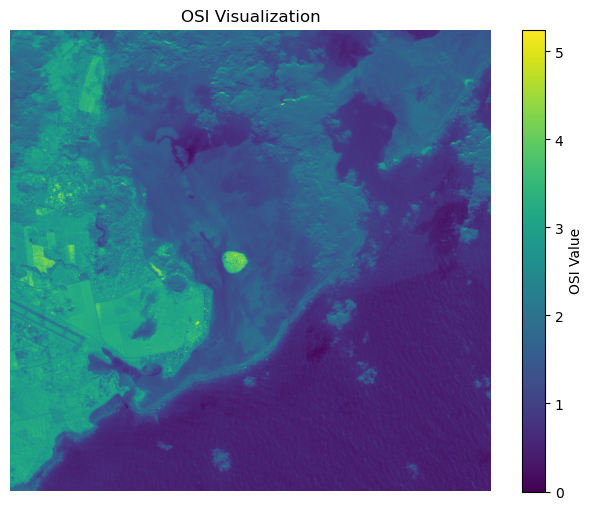

/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [62]:
#OSI = (B03 + B04) / B02

osi = (filtered_date1_b03 + filtered_date1_b04) / filtered_date1_b02

plt.figure(figsize=(8, 6))
plt.imshow(osi, cmap='viridis')
plt.colorbar(label='OSI Value')
plt.title('OSI Visualization')
plt.axis('off')
plt.show()

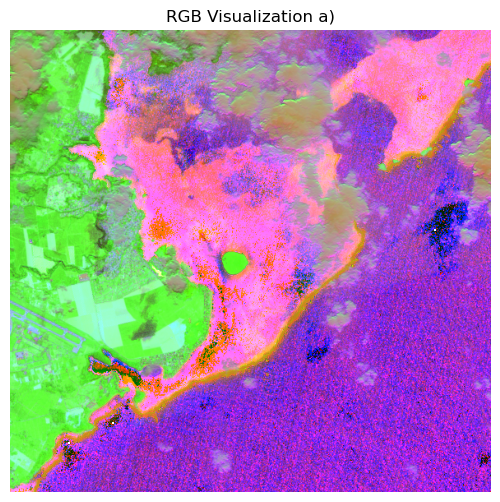

In [ ]:
filtered_date1_b05 = filtered_date1['b05']
filtered_date1_b06 = filtered_date1['b06']
filtered_date1_b07 = filtered_date1['b07']
filtered_date1_b08 = filtered_date1['b8a']
filtered_date1_b11 = filtered_date1['b11']
filtered_date1_b12 = filtered_date1['b12']

R = (filtered_date1_b05 + filtered_date1_b06) / filtered_date1_b07
G = (filtered_date1_b03 + filtered_date1_b04) / filtered_date1_b02
B = (filtered_date1_b11 + filtered_date1_b12) / filtered_date1_b08

rgb_a = np.stack([R/3, G/3, B/3], axis=-1)
rgb_a = np.clip(rgb_a, 0, 1)

plt.figure(figsize=(8, 6))
plt.imshow(rgb_a)
plt.title('RGB Visualization a)')
plt.axis('off')
plt.show()

(accessing-data)=
## Accessing data

In [ ]:
# Initialize the collection search
search = CollectionSearch(
    url="https://stac.core.eopf.eodc.eu/collections",
)

for collection_dict in search.collections_as_dicts():
    print(collection_dict["id"])

In [ ]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[56.9998077380456, -20.8876343730305, 58.0554474534573, -19.8927954124891],
        datetime=["2020-06-30", "2020-10-01"],
    ).items()
)
print(f"items found: {len(items)}")

(filter-spatial-extent)=
## Filter spatial extent
TODO: This will not be necessary with xcube_eopf

(calculate-osi)=
## Calcualate OSI

As mentioned before the formula for the OSI is:

```
OSI = (B03 + B04) / B02
```

(visualize-results)=
## Visualize results

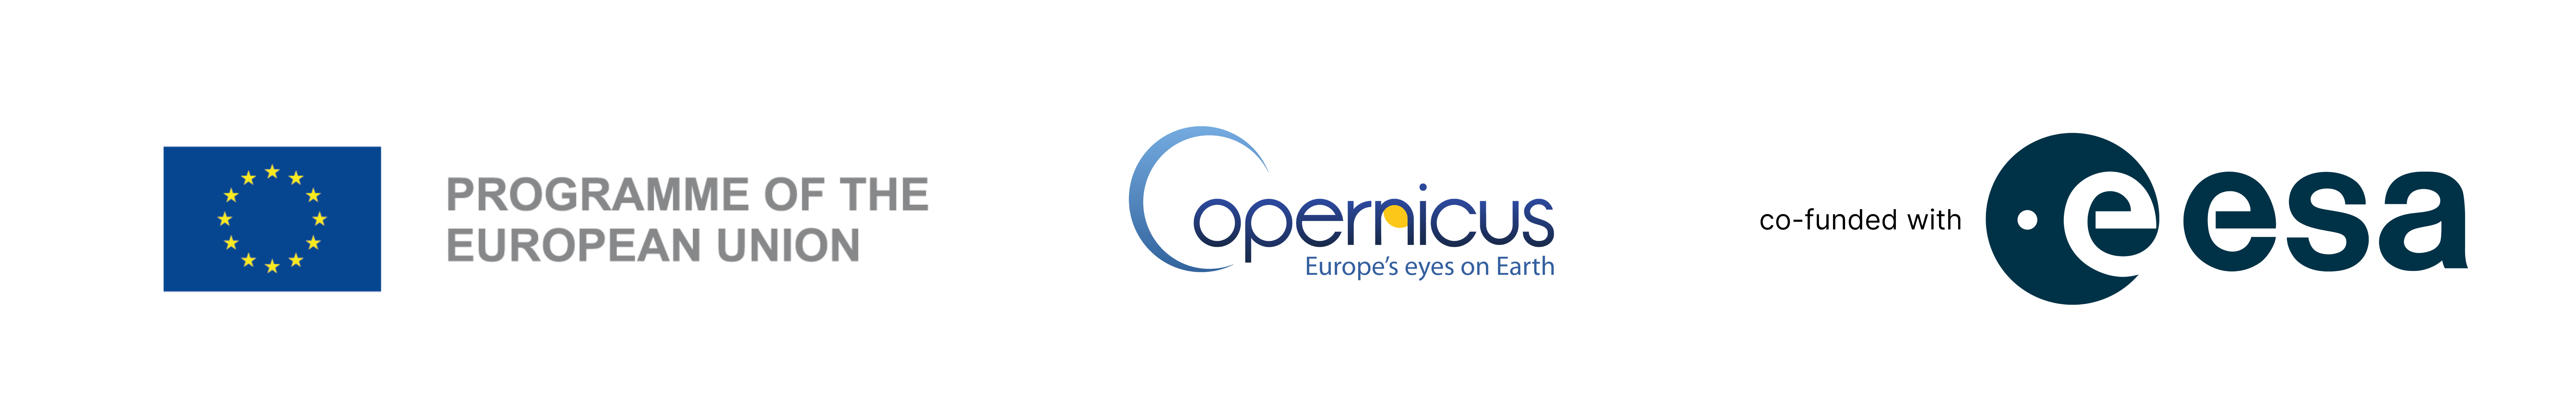